In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import pytorch_lightning
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

from src.utils.utils import training, testing, EarlyStopping, get_y_true_preds
from src.utils.LungDataset import LungSet
from src.model.LungNetwork import LungNet

import torch
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
seed=2024
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Number of available GPUs: 1


In [18]:
#config
prefix="6C"
num_classes = 6
id = ''

wholeslide_id = '100_A'
pred_split_path = "data/splits/100_A.csv"
pred_data_path = "data/100_A"

baseline_path = "src/model/tenpercent_resnet18.ckpt"
evaluate_model_path = f"checkpoints/supervised/{prefix}/last_model{id}.pth"
BATCH_SIZE = 24

save_dir = f"predictions/supervised/{prefix}{id}/{wholeslide_id}/"
os.makedirs(save_dir, exist_ok=True)

In [3]:
dpred = pd.read_csv(pred_split_path).sample(frac = 1)

# create a LungSet object(torch.Datatset) with:
# df(DataFrame): image_path, label
# data_path(str): directory containing the images
# transform(transforms.Compose): transformations to apply
# __iter__: return torch(Image), label
pred_set = LungSet(dpred, data_path=pred_data_path, file_name=True, predictions=True)

# Create the torch.Dataloader
pred_loader = DataLoader(pred_set, batch_size=BATCH_SIZE, shuffle=False)


In [4]:
model = LungNet(baseline_path, num_classes)

weights = torch.load(evaluate_model_path, map_location=device)
model.load_state_dict(weights)
model = model.cuda()

In [9]:
def predict(data_loader, model):
    model.eval()
    y_true = torch.zeros(0, dtype=torch.long, device='cpu')
    y_preds = torch.zeros(0, dtype=torch.long, device='cpu')
    patch_order = []

    with torch.no_grad():
        for data, targets, filenames in tqdm(data_loader):   
            data = data.cuda()
            targets = targets.cuda()
            scores = model(data)
            preds = torch.softmax(scores, dim=1).argmax(dim=1).detach() 
            y_true = torch.cat([y_true, targets.view(-1).cpu()])
            y_preds = torch.cat([y_preds, preds.view(-1).cpu()])
            patch_order.extend(filenames)
            del data, targets, scores, preds, filenames
    return y_true, y_preds, patch_order

In [10]:
y_true ,y_preds, filenames = predict(pred_loader, model)

100%|██████████| 280/280 [02:20<00:00,  1.99it/s]


In [13]:
y_preds.shape

torch.Size([6720])

In [15]:
len(filenames)

6720

In [22]:
def display_prediction(predictions, patch_order, save_name, title):
    T_COLOR = (255,0,0) 	 # red 
    FI_COLOR = (100, 216, 230) #light coral 	
    NE_COLOR = (138,43,226)  #blue violet
    TL_COLOR= (255,215,0)    #gold 
    H_COLOR = (255,192,203)
    P_COLOR= (50,205,50)    #lime green 
    list_classes = ['P', 'H', 'Né', 'TL', 'Fi', 'T']
    colors_pred = {0:P_COLOR, 1:H_COLOR, 2:NE_COLOR, 3:TL_COLOR, 4:FI_COLOR, 5:T_COLOR}
    idx_to_label = {'P':0, 'H':1, 'Né':2, 'TL':3, 'Fi':4, 'T':5}

    x_list = [int(patch.replace('.jpg', '').split("_")[3]) for patch in patch_order]
    y_list = [int(patch.replace('.jpg', '').split("_")[5]) for patch in patch_order]



    min_i = min(x_list)-15  #add 15 as a margin (optional)
    max_i = max(x_list)+15
    min_j = min(y_list)-15
    max_j = max(y_list)+15

    print("Let's display the predictions:")
    # visual_predictions = [np.zeros((max_j-min_j,max_i-min_i)) for _ in range(args.n_ways)]
    global_predictions = np.full((max_j-min_j,max_i-min_i,3),255)
    
    plt.figure(figsize=(10,10))
    #plt.title("Predictions_"+f'_gamma_{args.gamma}_alpha_{alpha}')

    for idx, patch in tqdm(enumerate(patch_order)):
        patient, slide, _, x, _, y = patch.replace('.jpg', '').split("_")
        x, y = int(x), int(y)

        global_predictions[y-min_j,x-min_i,:] = colors_pred[int(predictions[idx])]
    
    #plt.legend(handles=[mpatches.Patch(color=colors_pred[i], label=list_classes[i]) for i in range(6)], loc='upper right')
    # Create a list of patches
    patches = [mpatches.Patch(color=tuple(c/255 for c in color), label=list_classes[label]) for label, color in colors_pred.items()]
    plt.legend(handles=patches, loc='upper right')
    plt.title(title)

    plt.imshow(global_predictions)
    plt.savefig(save_name)

Let's display the predictions:


0it [00:00, ?it/s]

6720it [00:00, 264726.76it/s]


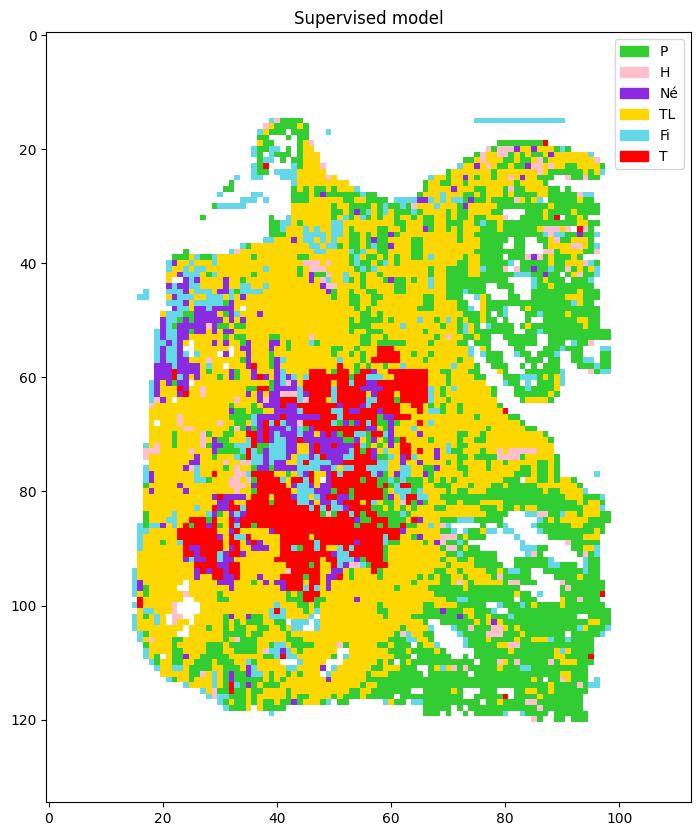

In [23]:
display_prediction(y_preds, filenames, save_name=save_dir + 'supervised_prediction.png', title='Supervised model')